In [1]:
import glob, os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

DATA_ROOT_PATH = "../szczury/better_data/"

# Data Loading # 

In [2]:
labels = pd.read_csv('./data/dlaUJ_VPAmodel_koh3_tickling_20190328.txt', delimiter="\t", index_col='Selection')

# 22-kHz indicate negative incentives, so probably should not be droped
# labels.drop(labels[labels['USV TYPE'] == '22-kHz'].index, inplace=True)
# labels.drop(labels[labels['USV TYPE'] == '22-kHz call'].index, inplace=True)

# 22-kHz labels normalization
labels.loc[labels['USV TYPE'] == '22-kHz call', 'USV TYPE'] = '22kHz'
labels.loc[labels['USV TYPE'] == '22-kHz', 'USV TYPE'] = '22kHz'

labels.head(10)

View  Channel  Begin Time (s)  End Time (s)  \
Selection                                                         
1          Spectrogram 1        1        3.906449      4.897027   
2          Spectrogram 1        1        4.982955      5.587635   
3          Spectrogram 1        1        5.691707      5.926661   
4          Spectrogram 1        1        6.178659      6.742458   
5          Spectrogram 1        1        7.165841      7.683367   
6          Spectrogram 1        1        7.792582      8.454765   
7          Spectrogram 1        1        8.661988      9.512852   
8          Spectrogram 1        1        9.650617      9.987997   
9          Spectrogram 1        1       10.084559     11.013766   
10         Spectrogram 1        1       11.151320     11.702782   

           Delta Time (s)  Low Freq (Hz)  High Freq (Hz)  Center Freq (Hz)  \
Selection                                                                    
1                   0.991        19622.1         27374.0           22460.9   
2                   0.605        19622.1         24951.6           21484.4   
3                   0.235        21075.6         24709.3           22949.2   
4                   0.564        19864.3         23740.3           21972.7   
5                   0.518        19864.3         23498.1           21484.4   
6                   0.662        20348.8         24224.8           21972.7   
7                   0.851        19864.3         23982.6           21972.7   
8                   0.337        20106.6         23498.1           21972.7   
9                   0.929        19379.8         24467.1           21972.7   
10                  0.551        20178.2         23584.9           21972.7   

           Peak Freq (Hz)                           Begin File  \
Selection                                                        
1                 23925.8  ch1-2018-11-20_10-17-43_0000004.wav   
2                 21972.7  ch1-2018-11-20_10-17-43_0000004.wav   
3                 24414.1  ch1-2018-11-20_10-17-43_0000004.wav   
4                 23437.5  ch1-2018-11-20_10-17-43_0000004.wav   
5                 21972.7  ch1-2018-11-20_10-17-43_0000004.wav   
6                 22460.9  ch1-2018-11-20_10-17-43_0000004.wav   
7                 21972.7  ch1-2018-11-20_10-17-43_0000004.wav   
8                 22460.9  ch1-2018-11-20_10-17-43_0000004.wav   
9                 22460.9  ch1-2018-11-20_10-17-43_0000004.wav   
10                22460.9  ch1-2018-11-20_10-17-43_0000004.wav   

           Delta Freq (Hz) USV TYPE  
Selection                            
1                   7751.9    22kHz  
2                   5329.5    22kHz  
3                   3633.7    22kHz  
4                   3876.0    22kHz  
5                   3633.8    22kHz  
6                   3876.0    22kHz  
7                   4118.3    22kHz  
8                   3391.5    22kHz  
9                   5087.3    22kHz  
10                  3406.7    22kHz

In [3]:
USV_TYPES = list(labels['USV TYPE'].unique())

print(USV_TYPES)

['22kHz', 'SH', 'FM', 'RP', 'FL', 'ST', 'CMP', 'IU', 'TR', 'RM']


In [4]:
assert os.path.exists(DATA_ROOT_PATH)

wavs = sorted(glob.glob(f"{DATA_ROOT_PATH}/*.wav"))

for wav in wavs:
    print(wav)

../szczury/better_data/ch1-2018-11-20_10-17-43_0000004.wav
../szczury/better_data/ch1-2018-11-20_10-20-34_0000006.wav
../szczury/better_data/ch1-2018-11-20_10-23-08_0000008.wav
../szczury/better_data/ch1-2018-11-20_10-26-36_0000010.wav
../szczury/better_data/ch1-2018-11-20_10-29-02_0000012.wav
../szczury/better_data/ch1-2018-11-20_10-31-42_0000014.wav
../szczury/better_data/ch1-2018-11-20_10-37-25_0000017.wav
../szczury/better_data/ch1-2018-11-20_10-39-58_0000019.wav
../szczury/better_data/ch1-2018-11-20_10-42-38_0000021.wav


## Calculate audio file offsets in data file ##

In [5]:
offsets, total_offset = {}, 0.0

for wav in wavs:
    name = os.path.basename(wav)
    duration = librosa.get_duration(filename=wav)
    print(f"{name}: {total_offset:.4f}s")
    offsets[name] = total_offset
    total_offset += duration
    
# print(offsets)

ch1-2018-11-20_10-17-43_0000004.wav: 0.0000s
ch1-2018-11-20_10-20-34_0000006.wav: 120.0049s
ch1-2018-11-20_10-23-08_0000008.wav: 240.0098s
ch1-2018-11-20_10-26-36_0000010.wav: 360.0147s
ch1-2018-11-20_10-29-02_0000012.wav: 480.0196s
ch1-2018-11-20_10-31-42_0000014.wav: 600.0245s
ch1-2018-11-20_10-37-25_0000017.wav: 720.0294s
ch1-2018-11-20_10-39-58_0000019.wav: 840.0343s
ch1-2018-11-20_10-42-38_0000021.wav: 960.0392s


In [6]:
labels['Relative Begin Time (s)'] = labels.apply (
    lambda row: row['Begin Time (s)'] - offsets[row['Begin File']],
    axis=1)

labels['Relative End Time (s)'] = labels.apply (
    lambda row: row['End Time (s)'] - offsets[row['Begin File']],
    axis=1
)

labels.tail()

View  Channel  Begin Time (s)  End Time (s)  \
Selection                                                         
2845       Spectrogram 1        1     1078.783906   1078.791993   
2846       Spectrogram 1        1     1079.182703   1079.224033   
2847       Spectrogram 1        1     1079.494477   1079.547487   
2848       Spectrogram 1        1     1079.715935   1079.757266   
2849       Spectrogram 1        1     1079.938759   1079.969308   

           Delta Time (s)  Low Freq (Hz)  High Freq (Hz)  Center Freq (Hz)  \
Selection                                                                    
2845                0.008        59291.6         67248.5           65918.0   
2846                0.041        53644.8         66221.8           62988.3   
2847                0.053        53131.4         69301.8           65429.7   
2848                0.041        51848.0         67505.1           63476.6   
2849                0.031        51334.7         63655.0           61523.4   

           Peak Freq (Hz)                           Begin File  \
Selection                                                        
2845              65918.0  ch1-2018-11-20_10-42-38_0000021.wav   
2846              62500.0  ch1-2018-11-20_10-42-38_0000021.wav   
2847              62988.3  ch1-2018-11-20_10-42-38_0000021.wav   
2848              62500.0  ch1-2018-11-20_10-42-38_0000021.wav   
2849              61523.4  ch1-2018-11-20_10-42-38_0000021.wav   

           Delta Freq (Hz) USV TYPE  Relative Begin Time (s)  \
Selection                                                      
2845                7956.9       RP               118.744738   
2846               12577.0       TR               119.143535   
2847               16170.4       TR               119.455309   
2848               15657.1       TR               119.676767   
2849               12320.3       TR               119.899591   

           Relative End Time (s)  
Selection                         
2845                  118.752825  
2846                  119.184865  
2847                  119.508319  
2848                  119.718098  
2849                  119.930140

## Analize distribution of `Center Freq (Hz)` ##

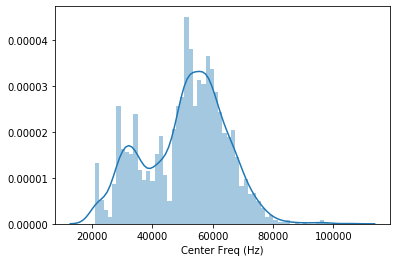

In [7]:
sns.distplot(labels['Center Freq (Hz)'], bins=60)

### Fit Gaussians to pdf ###
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [8]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(2)
data = np.array(labels[labels['USV TYPE'] != '22kHz']['Center Freq (Hz)']).reshape(-1, 1)
gm.fit(data)

assert gm.converged_

weights = gm.weights_
means = gm.means_.reshape(-1)
variances = gm.covariances_.reshape(-1)

# print('weights:', weights)
# print('means:', means)
# print('variances:', variances)
print('predicted Mixtures:')
for i, (w, mu, sigma2) in enumerate(zip(weights, means, variances)):
    print(f"#{i+1}: w = {w:.4f}, mu = {mu:.2f}, sigma = {np.sqrt(sigma2):.2f}")

predicted Mixtures:
#1: w = 0.1687, mu = 32057.94, sigma = 3329.24
#2: w = 0.8313, mu = 55947.25, sigma = 9736.73


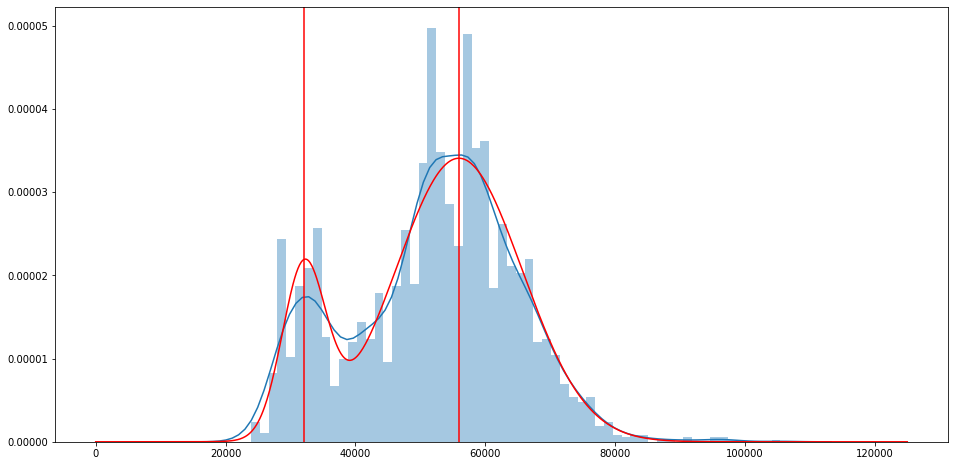

In [9]:
def normal(x, mu, sigma2):
    return (1/np.sqrt(2*np.pi*sigma2))*np.exp(-(x-mu)**2/(2*sigma2))

x = np.linspace(0, 250000/2, 1000)

y = sum(
    w*normal(x, mu, sigma2) 
    for w, mu, sigma2 in zip(weights, means, variances))

plt.figure(figsize=(16, 8))
sns.distplot(data, bins=60)
sns.lineplot(x, y, color='red')
for mean in means:
    plt.axvline(x=mean, color='red')

### Analize distribution of `Center Freq (Hz)` per `USV TYPE` ###

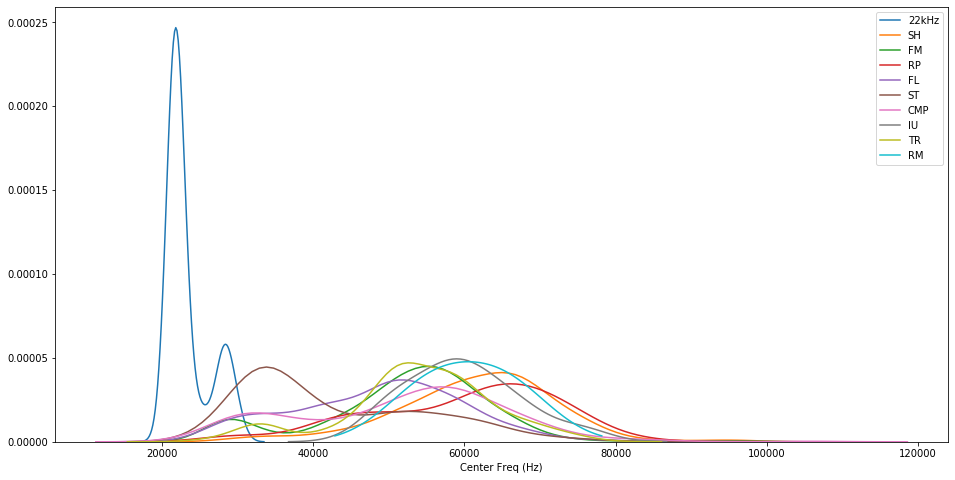

In [10]:
plt.figure(figsize=(16, 8))
for usv_type in USV_TYPES:
    sns.distplot(labels[labels['USV TYPE'] == usv_type]['Center Freq (Hz)'], hist=False, label=usv_type)
#     print(usv_type)

## Show single annotation ##

In [11]:
%matplotlib inline
# https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

def freq_to_fft_bucket(freq, n_fft, sr):
    return (n_fft//2 + 1) * freq / (sr / 2)

def get_audio(path):
    if path not in get_audio.cache:
        get_audio.cache[path] = librosa.load(path, sr=None)
    return get_audio.cache[path]
get_audio.cache = {}


def show_single_marker(row, n_fft=512, hop_length=128, ax=None, verbose=False, context_size=2048):
    if verbose:
        print(row)
    path = f"{DATA_ROOT_PATH}/{row['Begin File']}"
    
    y, sr = get_audio(path)
    assert sr == 250000
    
    start_frame = int(row['Relative Begin Time (s)'] * sr)
    end_frame = int(row['Relative End Time (s)'] * sr)
    
    if context_size is not None:
        middle_frame = (start_frame + end_frame) // 2

        start_frame = middle_frame - context_size
        end_frame = middle_frame + context_size
    
    stft = librosa.stft(y[start_frame: end_frame], n_fft=n_fft, hop_length=hop_length)

    D = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    librosa.display.specshow(D, x_axis=None, sr=sr, hop_length=hop_length, ax=ax)
    
    # show sample duration 
    ax.set_title(f"{row['Delta Time (s)']:.3f}s")
    
    # show marker for 'Center Freq'
    i = freq_to_fft_bucket(row['Center Freq (Hz)'], n_fft, sr)
    ax.set_yticks([i])
    ax.set_yticklabels([f"{row['Center Freq (Hz)']/1e3:.2f}kHz"], rotation='vertical')
    

# Display sample markers for each `USV TYPE` #

### WARNING: Coś jest nie tak z ch1-2018-11-20_10-17-43_0000004.wav #

### WARNING: Czy ch1-2018-11-20_10-31-42_0000014.wav jest dobrze za annotowane? 22kHz wygląda podobnie do FM (FM zawiera RP) ##

ch1-2018-11-20_10-31-42_0000014.wav


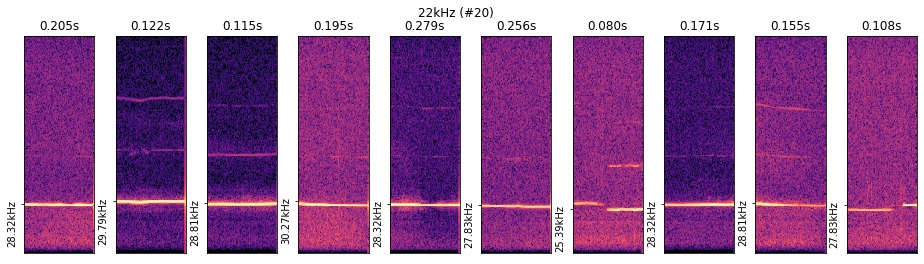

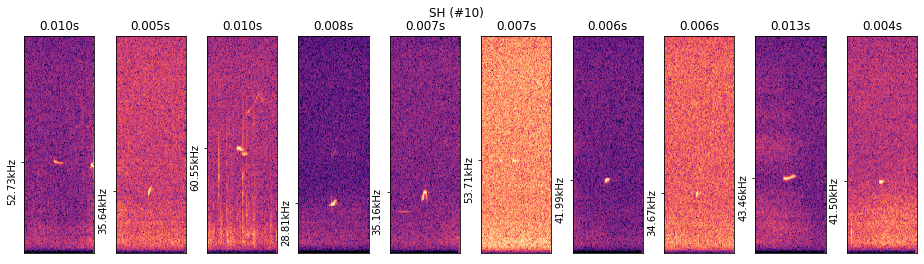

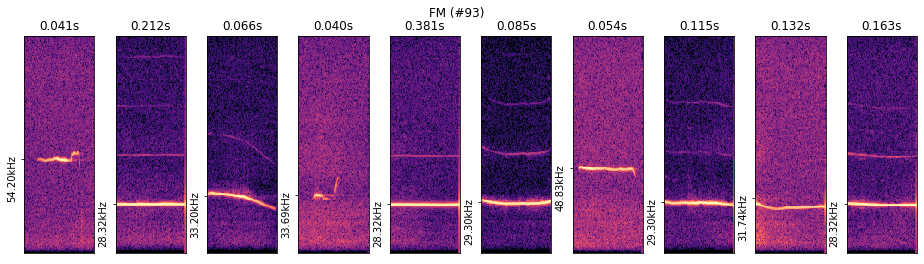

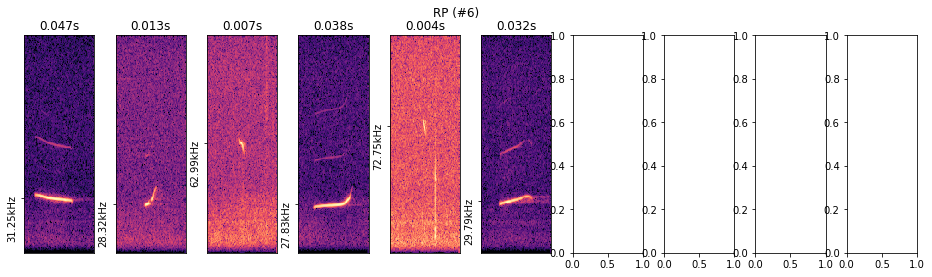

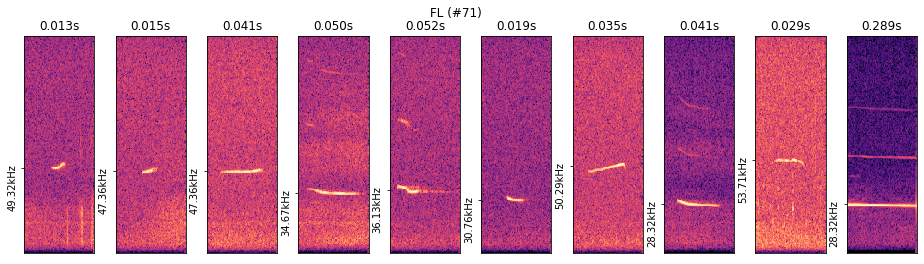

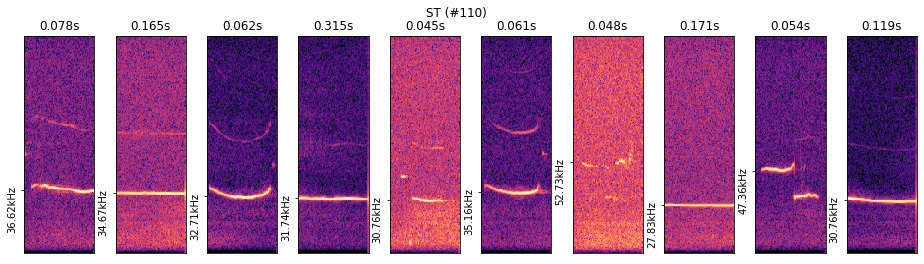

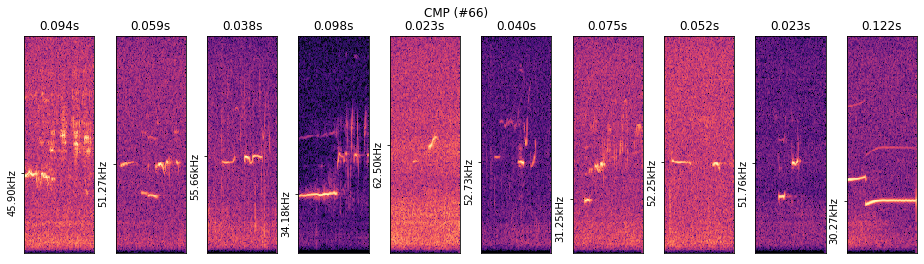

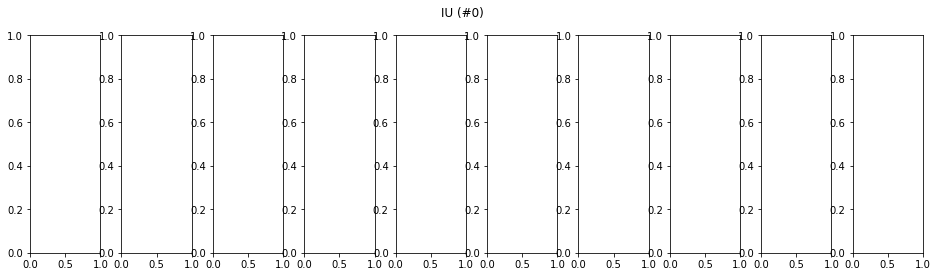

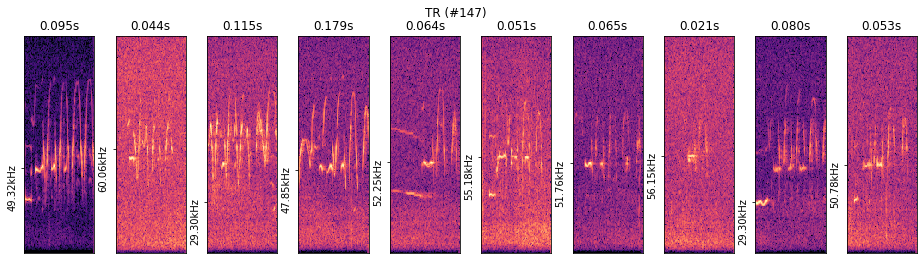

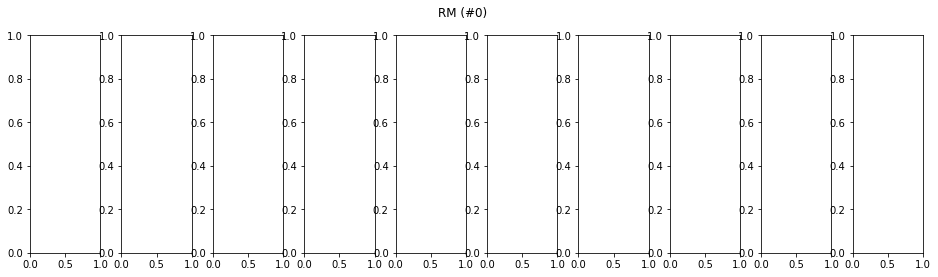

In [12]:
SOURCE_FILE = 'ch1-2018-11-20_10-20-34_0000006.wav'
SOURCE_FILE = os.path.basename(wavs[5])
print(SOURCE_FILE)

N = 10
for usv_type in USV_TYPES:
    rows = labels[
        (labels['Begin File'] == SOURCE_FILE) & 
        (labels['USV TYPE'] == usv_type)]
    
    fig, axs = plt.subplots(1, N, figsize=(16, 4))
    fig.suptitle(f"{usv_type} (#{len(rows)})")
    plt.subplots_adjust(wspace=0.3)

    for ax, (idx, row) in zip(axs, rows.sample(min(N, len(rows))).iterrows()):
        show_single_marker(row, ax=ax, context_size=8192)
    
# plt.colorbar(format='%+2.0f dB',)



# Generating dataset #

In [13]:
from types import SimpleNamespace

def extract_audio_frames(audio_name, data, n_fft=512, hop_length=128):
    audio_data, sr = get_audio(f"{DATA_ROOT_PATH}/{audio_name}")
    
    def t2f(time):
        return librosa.core.time_to_frames(time, sr=sr, hop_length=hop_length, n_fft=n_fft)

    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    stft = np.abs(np.moveaxis(stft, 0, -1))
    
    frames_labels = np.array([None]*stft.shape[0])
    for idx, row in data[data['Begin File'] == audio_name].iterrows():
        # WARNING: add some offset to range boundaries ???
        start = t2f(row['Relative Begin Time (s)'])
        end = t2f(row['Relative End Time (s)'])

        frames_labels[start:end] = row['USV TYPE']
    
    meta = dict(
        audio_name=audio_name,
        audio_length=audio_data.size,
        n_fft=n_fft,
        hop_length=hop_length,
        sampling_rate=sr,
    )
    
    return SimpleNamespace(
        X=stft, y=frames_labels, meta=meta
    )


In [14]:
data = extract_audio_frames(SOURCE_FILE, labels)
print(data.X.shape, data.y.shape)
print(data.meta)

(234385, 257) (234385,)
{'audio_name': 'ch1-2018-11-20_10-31-42_0000014.wav', 'audio_length': 30001224, 'n_fft': 512, 'hop_length': 128, 'sampling_rate': 250000}


## Check precision of annotations ##

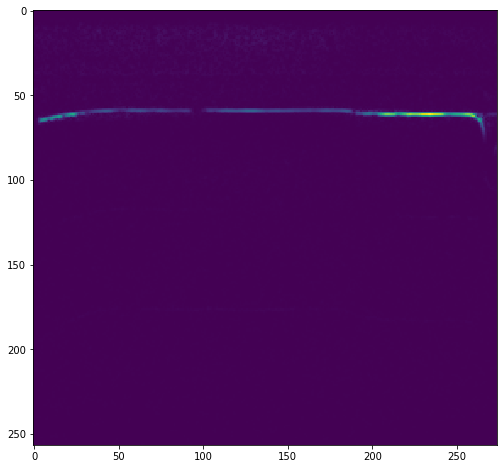

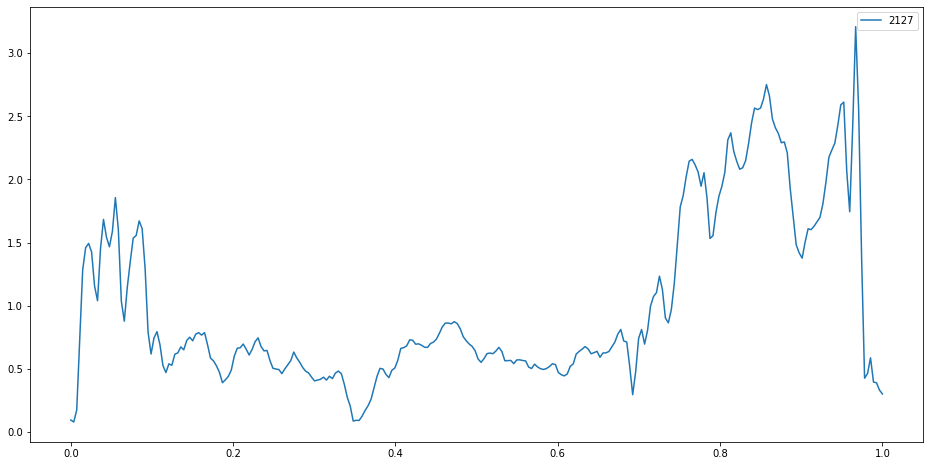

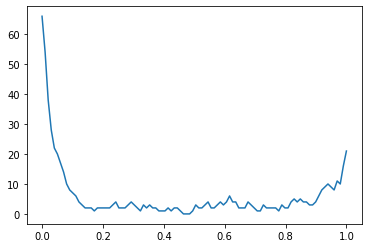

In [15]:
def check_annotation_precision(data, labels, n=100):
    N_buckets = 100
    buckets = np.zeros(shape=N_buckets)
    buckets_x = np.linspace(0, 1.0, N_buckets)

    plt.figure(figsize=(16,8))

    done = False
    audio_name = data.meta['audio_name']
    sr, hop_length, n_fft = data.meta['sampling_rate'], data.meta['hop_length'], data.meta['n_fft']
    
    for idx, row in labels[labels['Begin File']==audio_name].sample(n).iterrows():
        low = int(freq_to_fft_bucket(row['Low Freq (Hz)'], n_fft=n_fft, sr=sr))
        high = int(freq_to_fft_bucket(row['High Freq (Hz)'], n_fft=n_fft, sr=sr))+1
        start = librosa.core.time_to_frames(row['Relative Begin Time (s)'], sr=sr, hop_length=hop_length, n_fft=n_fft)
        end = librosa.core.time_to_frames(row['Relative End Time (s)'], sr=sr, hop_length=hop_length, n_fft=n_fft)

        frame = np.sum(data.X[start:end, low:high], axis=1)
        frame *= frame.size / frame.sum() # normalize

        t = np.linspace(0, 1, frame.size)    
        if not done:
            plt.imshow(data.X[start:end,].T)
            plt.figure(figsize=(16, 8))
            done = True
            sns.lineplot(t, frame, label=f"{idx}")

        zzz = np.interp(buckets_x, t, frame, 0.0, 0.0)
        buckets += (zzz < 0.2)

    plt.figure()
    sns.lineplot(buckets_x, buckets)
    
check_annotation_precision(data, labels)

## Display single frame ##

None 135417
22kHz 7104
SH 148
FM 23142
RP 278
FL 9372
ST 24023
CMP 13948
IU 0
TR 20953
RM 0


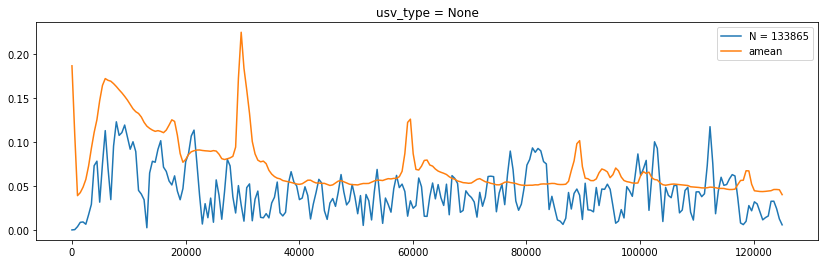

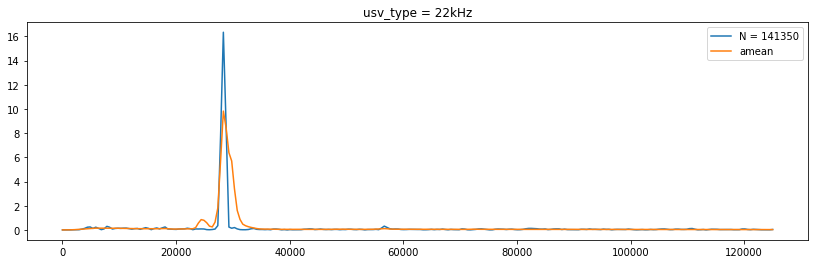

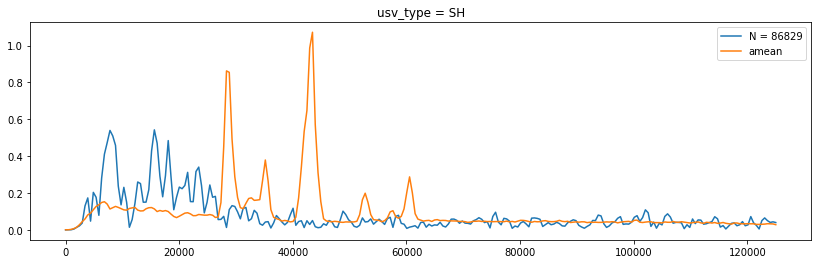

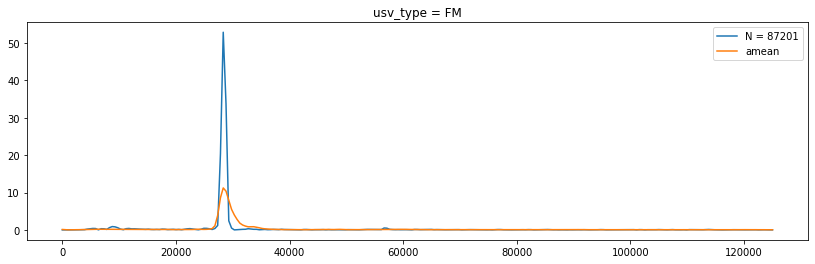

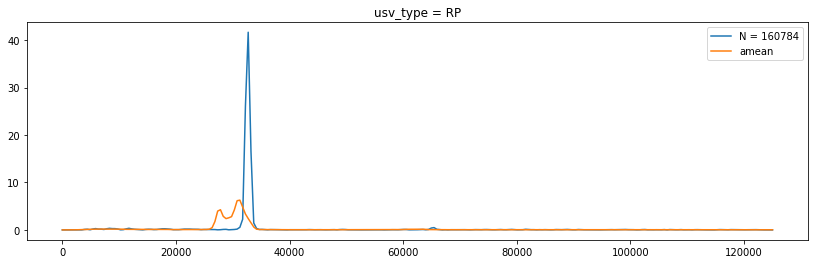

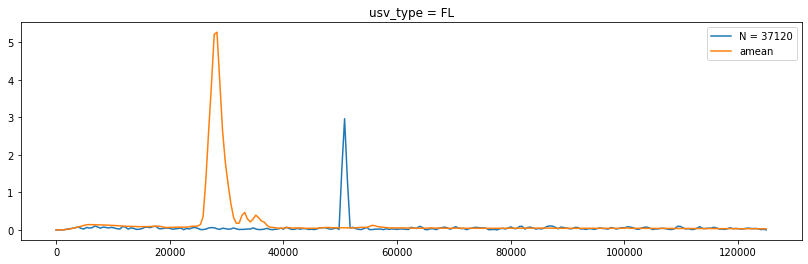

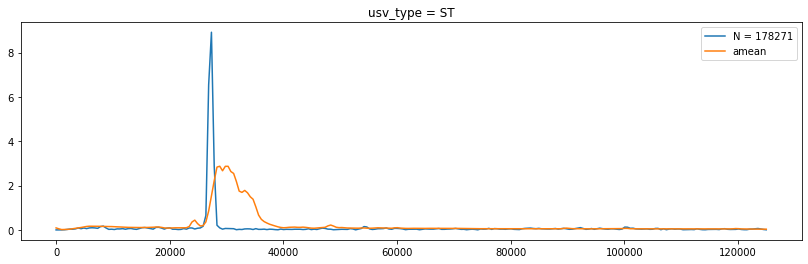

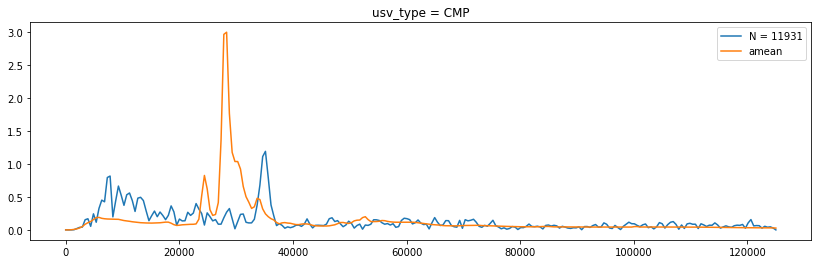

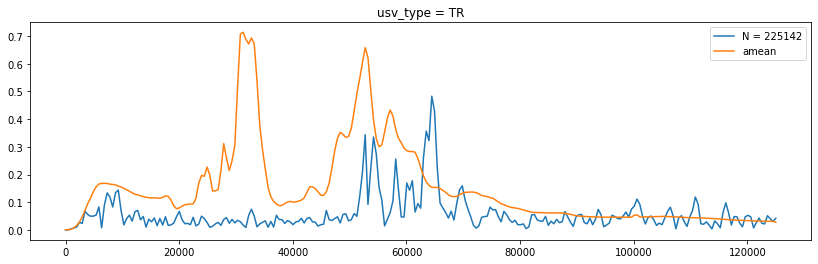

In [16]:
%matplotlib inline


def show_frame(data, usv_type):
    idx = np.argwhere(data.y == usv_type).reshape(-1)
    print(usv_type, idx.size)
    
    if not idx.size:
        return 
    
    x_hz = librosa.core.fft_frequencies(250000, data.meta['n_fft'])
    
    # display single sample of usv_type
    N = np.random.choice(idx)
    plt.figure(figsize=(14,4))
    sns.lineplot(x_hz, data.X[N], label=f"N = {N}").set_title(f"usv_type = {usv_type}")
#     print(y[N-10:N+10])
    
    # display average for given usv_type
    avg = np.mean(data.X[idx], axis=0)
    sns.lineplot(x_hz, avg, label='amean')


for usv_type in [None] + USV_TYPES:
    show_frame(data, usv_type)

## Save FFTs and labels ##

In [17]:
print(data.X.shape, data.y.shape)
print(data.X.dtype, data.y.dtype)
print(data.meta)

np.savez('dataset.npz', X=data.X, y=data.y, meta=data.meta)

!wc dataset.npz

(234385, 257) (234385,)
float32 object
{'audio_name': 'ch1-2018-11-20_10-31-42_0000014.wav', 'audio_length': 30001224, 'n_fft': 512, 'hop_length': 128, 'sampling_rate': 250000}
   777608   4542119 241282848 dataset.npz


## TODO: Masking training ##